In [1]:
#%matplotlib widget
# To support seeing my workspace only for python files
import sys
import os
import re
import numpy as np
import pandas as pd
from pathlib import Path
_my_worksparce = os.getcwd()
sys.path.append(_my_worksparce)
import librosa 
#from scipy.io import wavfile
import matplotlib.pyplot as plt
from utils.functions import *

# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

To install packages:
`python -m pip install [package name]`

In [2]:
#############
# CONSTANTS #
#############
MY_WORKSPACE = Path(_my_worksparce)
# Resource_directory is where the WAV files are stored
resource_directory = MY_WORKSPACE / "resource1"
label_directory = MY_WORKSPACE / "labels"

In [3]:

#! Part One - plotting the signals, fft, spectrogram
# os.listdir(resource_directory)
# print(resource_directory)
# apply_to_all_wav_files(resource_directory, apply_fft_and_display)
# apply_to_all_wav_files(resource_directory, apply_spectrogram_and_display)
# apply_to_all_wav_files(resource_directory, filter_and_display)
#apply_to_all_wav_files(resource_directory, spectrogram_fft_before_and_after_filter)

In [4]:

#! part two - feature extruction
data = [] 

def extract_features():
    data = [] 
    for filename in os.listdir(resource_directory):
        if filename.endswith(".WAV"):
            filepath = os.path.join(resource_directory, filename)
            label_file = os.path.join(label_directory, filename.replace(".WAV", ".txt"))
            print(f"file number = {filename}")
            audio, fs_rate = load_wav(filepath)
            print(f"audio length = {len(audio)}")

            filtered_audio = chebyshev_bandpass_filter(audio, 300, 19000, fs_rate, ripple=20)
            high_quality_intervals, average_first_peak_time, breathing_rate = process_audio_breathing_rate(filtered_audio, fs_rate)
            print(f"Number of Quality Intervals {filename}: {len(high_quality_intervals)}")
            average_spectral_centroid = calculate_average_spectral_centroid(high_quality_intervals, fs_rate)
            print(f"Average Spectral Centroid for {filename}: {average_spectral_centroid} Hz")

            inhalation_segments, exhalation_segments, avg_inhalation_time, avg_exhalation_time = calculate_average_breath_times(label_file)
            print(f"Average Inhalation Time for {filename}: {avg_inhalation_time} seconds")
            print(f"Average Exhalation Time for {filename}: {avg_exhalation_time} seconds")
            time_ratio = avg_exhalation_time / avg_inhalation_time if avg_inhalation_time != 0 else 0
            print(f"Time Ratio for {filename}: {time_ratio}")

            avg_inhalation_energy = calculate_segment_energy(filtered_audio, fs_rate, inhalation_segments)
            avg_exhalation_energy = calculate_segment_energy(filtered_audio, fs_rate, exhalation_segments)
            print(f"Average Inhalation Energy for {filename}: {avg_inhalation_energy} dB")
            print(f"Average Exhalation Energy for {filename}: {avg_exhalation_energy} dB")
            energy_ratio = avg_exhalation_energy - avg_inhalation_energy if avg_inhalation_energy != 0 else float('inf')
            print(f"Energy Ratio for {filename}: {energy_ratio}")

            data.append([
                filename, breathing_rate, average_spectral_centroid, avg_inhalation_time, avg_exhalation_time, 
                time_ratio, avg_inhalation_energy, avg_exhalation_energy, energy_ratio
            ])

    columns = ['filename', 'breathing_rate', 'average_spectral_centroid', 'avg_inhalation_time', 
               'avg_exhalation_time', 'time_ratio', 'avg_inhalation_energy', 'avg_exhalation_energy', 'energy_ratio']
    df = pd.DataFrame(data, columns=columns)
    df.to_csv('extracted_features.csv', index=False)

# Call the function to extract features and save to CSV
extract_features()

file number = ZOOM0033.WAV
audio length = 5035246
Number of intervals: 21
Average first peak time: 0.994421768707483 seconds
BR = 60 breaths in one minute
Number of Quality Intervals ZOOM0033.WAV: 3
Average Spectral Centroid for ZOOM0033.WAV: 507.69986921531324 Hz
Average Inhalation Time for ZOOM0033.WAV: 0.18773075000000064 seconds
Average Exhalation Time for ZOOM0033.WAV: 0.19872054166666675 seconds
Time Ratio for ZOOM0033.WAV: 1.0585401787755393
Average Inhalation Energy for ZOOM0033.WAV: -66.06688853187498 dB
Average Exhalation Energy for ZOOM0033.WAV: -63.72065213932376 dB
Energy Ratio for ZOOM0033.WAV: 2.3462363925512193
file number = ZOOM0036.WAV
audio length = 7453568
Number of intervals: 32
Average first peak time: 0.8614195011337868 seconds
BR = 70 breaths in one minute
Number of Quality Intervals ZOOM0036.WAV: 5
Average Spectral Centroid for ZOOM0036.WAV: 508.58759483229795 Hz
Average Inhalation Time for ZOOM0036.WAV: 0.2005713478260863 seconds
Average Exhalation Time for ZO

label
1    14
0    13
Name: count, dtype: int64
Average Accuracy over 100 iterations: 0.731111111111111 ± 0.14755622489808026
Average Sensitivity over 100 iterations: 0.7179047619047617 ± 0.22015873216145385
Average Specificity over 100 iterations: 0.768904761904762 ± 0.19543857883037857


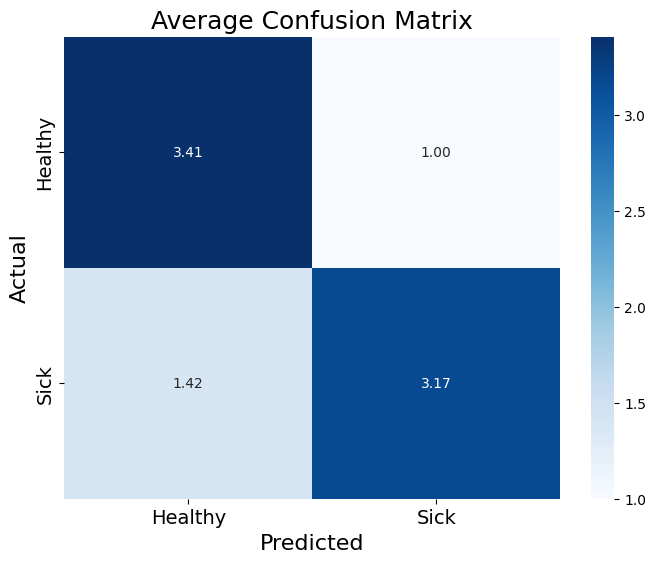

In [5]:

#!part three- SVM 
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Dictionary mapping filenames to Tal's scores
tals_scores = {
    'ZOOM0033.WAV': 11, 'ZOOM0036.WAV': 9, 'ZOOM0043.WAV': 8, 'ZOOM0046.WAV': 7, 'ZOOM0047.WAV': 6, 'ZOOM0049.WAV': 10,
    'ZOOM0053.WAV': 8, 'ZOOM0057.WAV': 6, 'ZOOM0059.WAV': 7, 'ZOOM0063.WAV': 7, 'ZOOM0064.WAV': 7, 'ZOOM0067.WAV': 9,
    'ZOOM0068.WAV': 7, 'ZOOM0074.WAV': 7, 'ZOOM0076.WAV': 7, 'ZOOM0087.WAV': 0, 'ZOOM0094.WAV': 0, 'ZOOM0099.WAV': 0,
    'ZOOM0102.WAV': 0, 'ZOOM0107.WAV': 0, 'ZOOM0109.WAV': 0, 'ZOOM0112.WAV': 0, 'ZOOM0114.WAV': 0, 'ZOOM0115.WAV': 0,
    'ZOOM0117.WAV': 0, 'ZOOM0118.WAV': 0, 'ZOOM0081.WAV': 8
}

# Dictionary mapping filenames to Genders
genders = {
    'ZOOM0033.WAV':'F', 'ZOOM0036.WAV': 'F', 'ZOOM0043.WAV': 'M', 'ZOOM0046.WAV': 'F', 'ZOOM0047.WAV': 'F', 'ZOOM0049.WAV': 'M',
    'ZOOM0053.WAV': 'M', 'ZOOM0057.WAV': 'M', 'ZOOM0059.WAV': 'M', 'ZOOM0063.WAV': 'M', 'ZOOM0064.WAV': 'M', 'ZOOM0067.WAV': 'F',
    'ZOOM0068.WAV': 'F', 'ZOOM0074.WAV': 'M', 'ZOOM0076.WAV': 'M', 'ZOOM0087.WAV': 'F', 'ZOOM0094.WAV': 'F', 'ZOOM0099.WAV': 'M',
    'ZOOM0102.WAV': 'M', 'ZOOM0107.WAV': 'F', 'ZOOM0109.WAV': 'M', 'ZOOM0112.WAV': 'F', 'ZOOM0114.WAV': 'M', 'ZOOM0115.WAV': 'F',
    'ZOOM0117.WAV': 'M', 'ZOOM0118.WAV': 'F', 'ZOOM0081.WAV': 'F'
}

# Dictionary mapping filenames to Ages [In Months]
ages_months = {
    'ZOOM0033.WAV': 1, 'ZOOM0036.WAV': 12, 'ZOOM0043.WAV': 10, 'ZOOM0046.WAV': 0.5, 'ZOOM0047.WAV': 2, 'ZOOM0049.WAV': 3,
    'ZOOM0053.WAV': 7, 'ZOOM0057.WAV': 6, 'ZOOM0059.WAV': 10, 'ZOOM0063.WAV': 2, 'ZOOM0064.WAV': 9, 'ZOOM0067.WAV': 1,
    'ZOOM0068.WAV': 2, 'ZOOM0074.WAV': 6, 'ZOOM0076.WAV': 5, 'ZOOM0087.WAV': 3, 'ZOOM0094.WAV': 7, 'ZOOM0099.WAV': 1,
    'ZOOM0102.WAV': 0.2, 'ZOOM0107.WAV': 10, 'ZOOM0109.WAV': 18, 'ZOOM0112.WAV': 19, 'ZOOM0114.WAV': 15, 'ZOOM0115.WAV': 7,
    'ZOOM0117.WAV': 0.5, 'ZOOM0118.WAV': 1, 'ZOOM0081.WAV': 12
    
}
# Load the features from the CSV file
df = pd.read_csv('extracted_features.csv')

# Add the labels based on the Tal's scores
df['label'] = df['filename'].apply(lambda x: 1 if tals_scores.get(x, 0) >= 7 else 0)

# Check the balance of the dataset
print(df['label'].value_counts())

# Handle NaN values
imputer = SimpleImputer(strategy='mean')
X = df.drop(columns=['filename', 'label'])
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
y = df['label']

# Number of iterations
n_iterations = 100

# Initialize lists to store results
accuracies = []
sensitivities = []
specificities = []
confusion_matrices = []

for i in range(n_iterations):
    # Shuffle the data
    X, y = shuffle(X, y, random_state=42+i)  # Vary the random state

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42+i)

    # Train the SVM classifier
    clf = SVC(kernel='linear')
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_test)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Calculate average and standard deviation for each metric
avg_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

avg_sensitivity = np.mean(sensitivities)
std_sensitivity = np.std(sensitivities)

avg_specificity = np.mean(specificities)
std_specificity = np.std(specificities)

# Print results
print(f'Average Accuracy over {n_iterations} iterations: {avg_accuracy} ± {std_accuracy}')
print(f'Average Sensitivity over {n_iterations} iterations: {avg_sensitivity} ± {std_sensitivity}')
print(f'Average Specificity over {n_iterations} iterations: {avg_specificity} ± {std_specificity}')

# Calculate average confusion matrix
avg_confusion_matrix = np.mean(confusion_matrices, axis=0)

# Display the average confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(avg_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Healthy', 'Sick'], yticklabels=['Healthy', 'Sick'])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.set_xlabel('Predicted', fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_title('Average Confusion Matrix', fontsize=18)
plt.show()

C:\Users\97250\AppData\Local\Temp\ipykernel_16644\892554294.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gender', y='breathing_rate', data=df, palette=custom_palette)


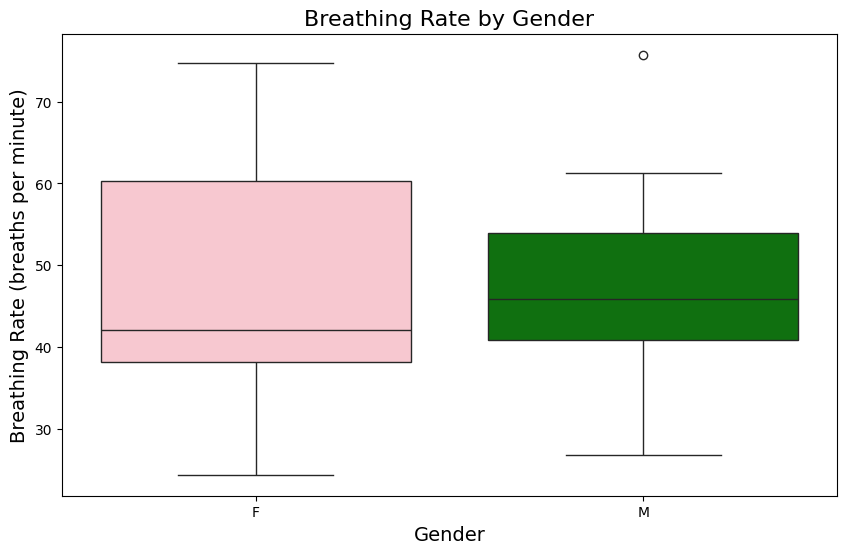

C:\Users\97250\AppData\Local\Temp\ipykernel_16644\892554294.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='age_months', y='breathing_rate', data=df, ci=None, estimator='mean', color='red')


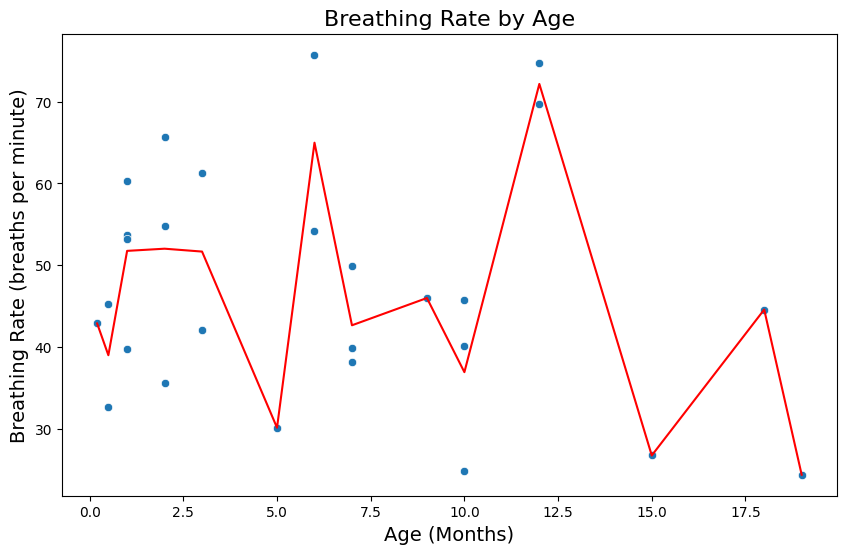

In [15]:
# Tal's scores, genders, and ages to the dataframe
df['tal_score'] = df['filename'].map(tals_scores)
df['gender'] = df['filename'].map(genders)
df['age_months'] = df['filename'].map(ages_months)

# Define custom colors for the boxplot
custom_palette = {'F': 'pink', 'M': 'green'}
# Plot the relationship between gender and breathing rate
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='breathing_rate', data=df, palette=custom_palette)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Breathing Rate (breaths per minute)', fontsize=14)
plt.title('Breathing Rate by Gender', fontsize=16)
plt.show()

# Plot the relationship between age and breathing rate
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age_months', y='breathing_rate', data=df)
sns.lineplot(x='age_months', y='breathing_rate', data=df, ci=None, estimator='mean', color='red')
plt.xlabel('Age (Months)', fontsize=14)
plt.ylabel('Breathing Rate (breaths per minute)', fontsize=14)
plt.title('Breathing Rate by Age', fontsize=16)
plt.show()

Average Mean Squared Error over 100 iterations: 11.79798341371762 ± 3.996471691638449
Average R-squared over 100 iterations: 0.11629312793463759 ± 0.44303021923132946


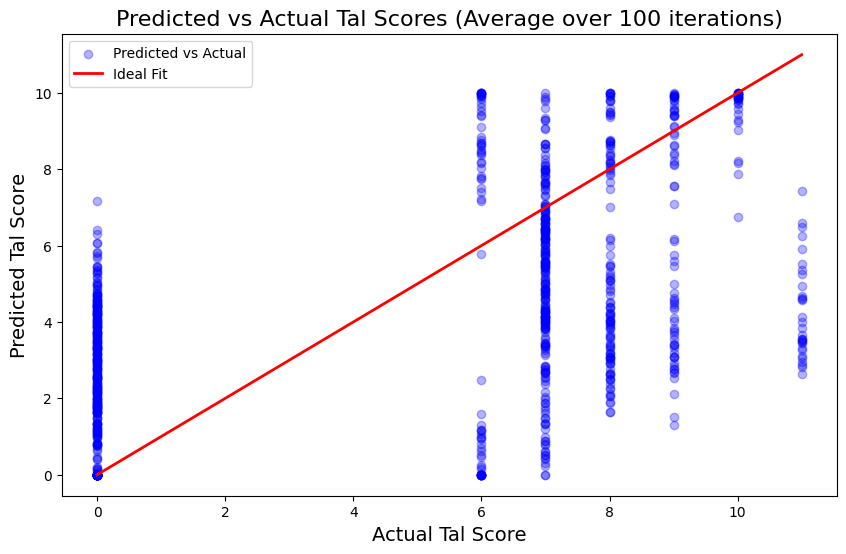

In [24]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Load the features from the CSV file
df = pd.read_csv('extracted_features.csv')

# Add Tal's score as the target variable
df['tal_score'] = df['filename'].map(tals_scores)

# Handle NaN values
imputer = SimpleImputer(strategy='mean')
X = df.drop(columns=['filename', 'tal_score'])
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
y = df['tal_score']

# Initialize lists to store results
mse_list = []
r2_list = []
all_y_test = []
all_y_pred = []

def compress_high_scores(score, threshold=9, scale=1):
    return score if score <= threshold else threshold + scale * np.tanh((score - threshold))

# Perform the process for 100 iterations
n_iterations = 100
for i in range(n_iterations):
    # Split the data into training (70%) and testing (30%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    # Train the SVM regressor
    svr = SVR(kernel='linear')
    svr.fit(X_train, y_train)

    # Predict on the test set
    y_pred = svr.predict(X_test)
    # Apply condition: Predicted Tal score cannot be below zero
    y_pred = np.maximum(y_pred, 0)  # Lower bound condition
    y_pred = np.minimum(y_pred, 12)  # Upper bound condition
    y_pred = np.array([compress_high_scores(score) for score in y_pred])
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    mse_list.append(mse)
    r2_list.append(r2)
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

# Calculate the average and standard deviation for MSE and R²
avg_mse = np.mean(mse_list)
std_mse = np.std(mse_list)
avg_r2 = np.mean(r2_list)
std_r2 = np.std(r2_list)

print(f'Average Mean Squared Error over {n_iterations} iterations: {avg_mse} ± {std_mse}')
print(f'Average R-squared over {n_iterations} iterations: {avg_r2} ± {std_r2}')

# Plot the average predicted vs actual Tal scores
plt.figure(figsize=(10, 6))
plt.scatter(all_y_test, all_y_pred, color='blue', alpha=0.3, label='Predicted vs Actual')
plt.plot([min(all_y_test), max(all_y_test)], [min(all_y_test), max(all_y_test)], color='red', linewidth=2, label='Ideal Fit')
plt.xlabel('Actual Tal Score', fontsize=14)
plt.ylabel('Predicted Tal Score', fontsize=14)
plt.title('Predicted vs Actual Tal Scores (Average over 100 iterations)', fontsize=16)
plt.legend()
plt.show()

In [19]:

#? Statistic graphs
from scipy import stats
# Perform T-tests for each feature
features = ['energy_ratio', 'time_ratio', 'breathing_rate', 'average_spectral_centroid']

print('{features}')
t_test_results = {}
for feature in features:
    healthy = df[df['label'] == 0][feature]
    sick = df[df['label'] == 1][feature]
    t_stat, p_val = stats.ttest_ind(healthy, sick, equal_var=False)
    t_test_results[feature] = (t_stat, p_val)

# Print T-test results
for feature, (t_stat, p_val) in t_test_results.items():
    print(f'T-test for {feature}: t-statistic = {t_stat:.4f}, p-value = {p_val:.4e}')

# Visualize the features using boxplots
plt.figure(figsize=(16, 12))

# Energy Ratio
plt.subplot(2, 2, 2)
sns.boxplot(x='label', y='energy_ratio', data=df)
plt.title('Energy Ratio [dB]: Healthy vs Sick', fontsize=20)
plt.xlabel('Label', fontsize=16)
plt.ylabel('Energy Ratio', fontsize=16)
plt.xticks([0, 1], ['Healthy', 'Sick'], fontsize=14)
plt.yticks(fontsize=14)

# Time Ratio
plt.subplot(2, 2, 4)
sns.boxplot(x='label', y='time_ratio', data=df)
plt.title('Prolonged Expiration: Healthy vs Sick', fontsize=20)
plt.xlabel('Label', fontsize=16)
plt.ylabel('Prolonged Expiration', fontsize=16)
plt.xticks([0, 1], ['Healthy', 'Sick'], fontsize=14)
plt.yticks(fontsize=14)

# Breathing Rate
plt.subplot(2, 2, 1)
sns.boxplot(x='label', y='breathing_rate', data=df)
plt.title('Breathing Rate: Healthy vs Sick', fontsize=20)
plt.xlabel('Label', fontsize=16)
plt.ylabel('Breathing Rate', fontsize=16)
plt.xticks([0, 1], ['Healthy', 'Sick'], fontsize=14)
plt.yticks(fontsize=14)

# Average Spectral Centroid
plt.subplot(2, 2, 3)
sns.boxplot(x='label', y='average_spectral_centroid', data=df)
plt.title('Spectral Centroid [Hz]: Healthy vs Sick', fontsize=20)
plt.xlabel('Label', fontsize=16)
plt.ylabel('Average Spectral Centroid', fontsize=16)
plt.xticks([0, 1], ['Healthy', 'Sick'], fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

{features}


KeyError: 'label'

Correlation between BR and DOCTOR_BR: 0.7593363375612202
Regression line: y = 0.92x + 0.19
Errors from y=x line: [  0   6 -14 -11   0  -3  -2   2  -4  -9 -14  -2   6   2 -18]
Mean Absolute Error (MAE): 6.2
Variance of BR: 130.78095238095236
Variance of DOCTOR_BR: 88.83809523809522
Paired t-test p-value: 0.053719869184478526
Effect Size (Cohen's d): -0.38807759645860096
Skewness of BR: 0.029107921173153084
Skewness of DOCTOR_BR: -0.8400330241741064
Mean of BR: 50.06666666666667
Mean of DOCTOR_BR: 54.13333333333333


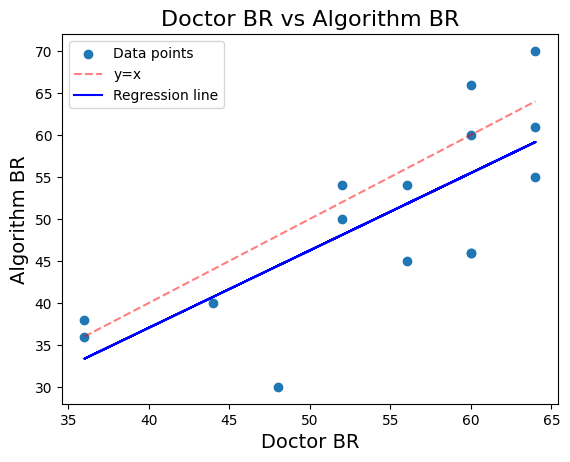

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Data
BR = np.array([60, 70, 46, 45, 36, 61, 50, 38, 40, 55, 46, 54, 66, 54, 30])
DOCTOR_BR = np.array([60, 64, 60, 56, 36, 64, 52, 36, 44, 64, 60, 56, 60, 52, 48])

# Calculate the correlation
correlation = np.corrcoef(BR, DOCTOR_BR)[0, 1]
print("Correlation between BR and DOCTOR_BR:", correlation)

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(DOCTOR_BR, BR)
print(f"Regression line: y = {slope:.2f}x + {intercept:.2f}")

# Plotting
fig, ax = plt.subplots()
ax.scatter(DOCTOR_BR, BR, label='Data points')
ax.plot([min(DOCTOR_BR), max(DOCTOR_BR)], [min(DOCTOR_BR), max(DOCTOR_BR)], 'r--', alpha=0.5, label='y=x')
ax.plot(DOCTOR_BR, slope * DOCTOR_BR + intercept, 'b-', label='Regression line')

# Add labels and title with increased font size
ax.set_xlabel('Doctor BR', fontsize=14)
ax.set_ylabel('Algorithm BR', fontsize=14)
ax.set_title('Doctor BR vs Algorithm BR', fontsize=16)
ax.legend()

# Calculate the errors from the y=x line
errors = BR - DOCTOR_BR
mean_absolute_error = np.mean(np.abs(errors))

# Print errors and mean absolute error
print("Errors from y=x line:", errors)
print("Mean Absolute Error (MAE):", mean_absolute_error)

# Calculate the variance
variance_BR = np.var(BR, ddof=1)  # Sample variance for BR
variance_DOCTOR_BR = np.var(DOCTOR_BR, ddof=1)  # Sample variance for DOCTOR_BR

# Perform a paired t-test
t_statistic, p_value = stats.ttest_rel(BR, DOCTOR_BR)

# Calculate the effect size (Cohen's d)
mean_diff = np.mean(errors)
pooled_std = np.sqrt((np.var(BR, ddof=1) + np.var(DOCTOR_BR, ddof=1)) / 2)
cohens_d = mean_diff / pooled_std

# Calculate skewness
skewness_BR = stats.skew(BR)
skewness_DOCTOR_BR = stats.skew(DOCTOR_BR)

# Calculate means
mean_BR = np.mean(BR)
mean_DOCTOR_BR = np.mean(DOCTOR_BR)

# Print the results
print("Variance of BR:", variance_BR)
print("Variance of DOCTOR_BR:", variance_DOCTOR_BR)
print("Paired t-test p-value:", p_value)
print("Effect Size (Cohen's d):", cohens_d)
print("Skewness of BR:", skewness_BR)
print("Skewness of DOCTOR_BR:", skewness_DOCTOR_BR)
print("Mean of BR:", mean_BR)
print("Mean of DOCTOR_BR:", mean_DOCTOR_BR)

plt.show()



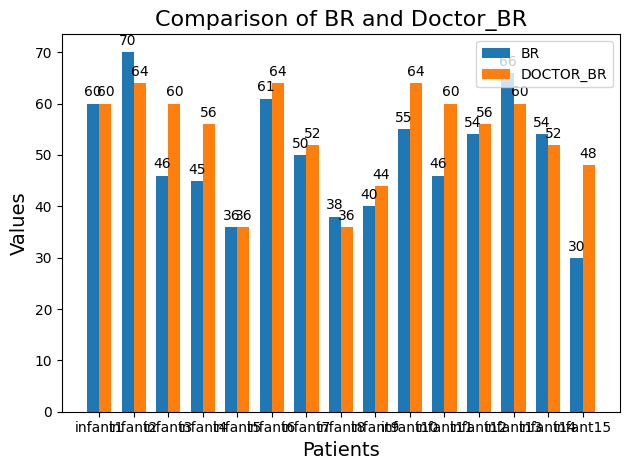

Differences: [  0   6 -14 -11   0  -3  -2   2  -4  -9 -14  -2   6   2 -18]
Errors: [ 0  6 14 11  0  3  2  2  4  9 14  2  6  2 18]
Mean Absolute Error (MAE): 6.2
Variance of BR: 130.78095238095236
Variance of DOCTOR_BR: 88.83809523809522
Paired t-test p-value: 0.053719869184478526
Effect Size (Cohen's d): -0.38807759645860096
Skewness of BR: 0.029107921173153084
Skewness of DOCTOR_BR: -0.8400330241741064
Mean of BR: 50.06666666666667
Mean of DOCTOR_BR: 54.13333333333333


In [21]:
# Data
BR = np.array([60, 70, 46, 45, 36, 61, 50, 38, 40, 55, 46, 54, 66, 54, 30])
DOCTOR_BR = np.array([60, 64, 60, 56, 36, 64, 52, 36, 44, 64, 60, 56, 60, 52, 48])

# Calculate the differences and errors
differences = BR - DOCTOR_BR
errors = np.abs(differences)

# Plotting
x = np.arange(len(BR))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, BR, width, label='BR')
rects2 = ax.bar(x + width/2, DOCTOR_BR, width, label='DOCTOR_BR')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Patients', fontsize=14)
ax.set_ylabel('Values', fontsize=14)
ax.set_title('Comparison of BR and Doctor_BR', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels([f'infant{i+1}' for i in range(len(BR))])
ax.legend()

# Attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# Print differences and errors
print("Differences:", differences)
print("Errors:", errors)

# Calculate the mean absolute error (MAE)
mae = np.mean(errors)
print("Mean Absolute Error (MAE):", mae)

# Calculate the variance
variance_BR = np.var(BR, ddof=1)  # Sample variance for BR
variance_DOCTOR_BR = np.var(DOCTOR_BR, ddof=1)  # Sample variance for DOCTOR_BR

# Perform a paired t-test
t_statistic, p_value = stats.ttest_rel(BR, DOCTOR_BR)

# Calculate the effect size (Cohen's d)
mean_diff = np.mean(differences)
pooled_std = np.sqrt((np.var(BR, ddof=1) + np.var(DOCTOR_BR, ddof=1)) / 2)
cohens_d = mean_diff / pooled_std

# Calculate skewness
skewness_BR = stats.skew(BR)
skewness_DOCTOR_BR = stats.skew(DOCTOR_BR)

# Calculate means
mean_BR = np.mean(BR)
mean_DOCTOR_BR = np.mean(DOCTOR_BR)

# Print the results
print("Variance of BR:", variance_BR)
print("Variance of DOCTOR_BR:", variance_DOCTOR_BR)
print("Paired t-test p-value:", p_value)
print("Effect Size (Cohen's d):", cohens_d)
print("Skewness of BR:", skewness_BR)
print("Skewness of DOCTOR_BR:", skewness_DOCTOR_BR)
print("Mean of BR:", mean_BR)
print("Mean of DOCTOR_BR:", mean_DOCTOR_BR)
